In [1]:
from src.utils import data_load
import pandas as pd
# from src.s3_utils import pandas_from_csv_s3
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_survey_question, na_rate
from hyperimpute.plugins.imputers import Imputers
import hyperimpute as hp
import os

In [132]:
# data = data_load(data_keys={'bodyport', 'oura_activity', 'oura_sleep', "surveys"})
df_birth = data_load(data_keys={"birth"})['birth']


Index(['user_id_x', 'record_id', 'redcap_event_name_x', 'date', 'birth_number',
       'birth_date', 'birth_scheduled', 'birth_scheduled_unsure',
       'birth_gestage', 'birth_mode', 'induction_yn', 'induction_reason',
       'vacuumforceps', 'vaginalaftercesarean', 'birth_c_type',
       'birth_incision', 'birth_indication', 'birth_apgar1', 'birth_apgar2',
       'birth_abnormal1', 'birth_describe1', 'conditionsknown',
       'birth_abnormal2', 'birth_describe2', 'conditionsknown_2',
       'birth_maternal___1', 'birth_maternal___2', 'birth_maternal___4',
       'hypertension', 'hellpsyndrome', 'birth_urine', 'postparhem',
       'hem_meds', 'birth_matmorbid', 'birth_describe', 'birth_stay',
       'birth_stay_baby', 'birth_stay_baby_yes', 'birth_feeding',
       'birth_matleave', 'birth_mat_leave_length',
       'birthing_data_cohort_2_only_complete', 'redcap_event_name_y',
       'participant_id', 'sema4_id', 'user_id_y', 'user_id_prior1',
       'user_id_prior2', 'user_id_c', 'stu

In [133]:
def get_survey_csv_by_date(selected_user, survey_question_str_lst, 
                           preset_start_date=datetime(2009, 10, 12, 10, 10), 
                           preset_end_date=datetime(2030, 10, 12, 10, 10)):
    root_path = os.path.join('/storage/home/ruizhu', 'dataset')
    # selected_user = 1441
    # print(f"Curr user: {selected_user}")
    # root_folder = file_name

    selected_data_survey_lst = []
    for q_str in survey_question_str_lst:
        csv_path = os.path.join(root_path, f'{q_str}/user_{selected_user}_{q_str}_label.csv')
        if not os.path.exists(csv_path):
            print(f"Empty {q_str}")
            return False
        survey_question_csv = pd.read_csv(csv_path).groupby("date", as_index = False).first()
        survey_question_csv = survey_question_csv.fillna(value=1.0)
        
        selected_data_survey_lst.append(survey_question_csv)


    def get_min_date(df):
        return np.min(df['date'].astype('datetime64[ns]'))
    def get_max_date(df):
        return np.max(df['date'].astype('datetime64[ns]'))

    ds_lst = selected_data_survey_lst
    overall_min_date = np.max(list(map(get_min_date, ds_lst)) + [preset_start_date])
    overall_max_date = np.min(list(map(get_max_date, ds_lst)) + [preset_end_date])
    
    date_range = pd.date_range(overall_min_date, overall_max_date, freq='d')
    # print(overall_max_date-overall_min_date)
    if overall_max_date-overall_min_date < timedelta(days=10):
        return False
    date_df = pd.DataFrame()
    date_df['date'] = date_range
    date_df['date'] = date_df['date'].astype("datetime64[ns]")
    def change_date_type(df):
        df['date'] = df['date'].astype('datetime64[ns]')
        return pd.merge(date_df, df, how='left')

    for i in range(len(ds_lst)):
        ds_lst[i] = change_date_type(ds_lst[i])


    unimputed_df = pd.DataFrame()
    unimputed_df['date'] = date_range

    for i in range(len(ds_lst)):
        unimputed_df = pd.merge(unimputed_df, ds_lst[i], how='left')
    # print("end")
    # print(len(unimputed_df))
    return unimputed_df

def get_aggregated_data(days_multiplier, symptom='fatigue'):
    counter = 0
    available_user = []
    if symptom == "fatigue":
        reliable_fatigue_user = [39, 84, 122, 137, 142, 174, 214, 225, 431, 581, 962, 966, 1002, 1032, 1363, 
                             1373, 1387, 1437, 1440, 1697, 1715, 1719, 1730, 1744, 1753, 2015, 2018, 2058, 
                             2062, 2068, 2109, 2150, 2153, 2159, 2167, 2214, 2265, 2312, 2318, 2339, 2340, 
                             2347, 2370, 2386, 2482, 2484, 2488, 2500, 2514, 2516, 2572, 2578, 2583, 2598, 2603, 2607, 2610, 2612, 2664]
    
    else:
        reliable_fatigue_user = [28, 29, 30, 35, 37, 38, 39, 42, 44, 45, 47, 53, 54, 64, 65, 66, 67, 68, 74, 
         75, 79, 80, 94, 95, 1431, 1393, 99, 114, 118, 119, 2093, 122, 124, 127, 135, 
         137, 155, 1014, 156, 158, 1373, 168, 1000, 173, 174, 185, 186, 1001, 190, 192, 
         193, 199, 200, 212, 1021, 972, 1724, 1004, 1429, 234, 975, 280, 289, 290, 291, 
         292, 404, 405, 407, 408, 409, 410, 977, 1047, 428, 581, 594, 595, 600, 603, 615,
         1658, 1045, 983, 966, 969, 985, 987, 989, 991, 992, 1005, 1455, 1038, 1044, 2117,
         2225, 2226, 2120, 1363, 1366, 1367, 1378, 1719, 2151, 1383, 1386, 1387, 1721,
         1425, 1426, 1427, 1432, 1436, 1439, 1440, 1443, 1697, 1452, 1700, 1703, 1706, 
         1707, 1708, 1709, 1710, 1712, 1715, 1716, 1728, 1731, 2299, 1743, 1745, 1749, 
         1750, 2187, 2091, 2197, 1976, 1988, 1989, 1994, 1995, 1996, 1997, 1999, 2000, 
         2001, 2004, 2014, 2016, 2018, 2019, 2038, 2032, 2056, 2058, 2060, 2061, 2062, 
         2064, 2068, 2076, 2202, 2645, 2654, 2084, 2223, 2311, 2100, 2102, 2109, 2158, 
         2159, 2160, 2166, 2169, 2174, 2176, 2178, 2212, 2235, 2664, 2650, 2265, 2339, 
         2340, 2341, 2342, 2260, 2510, 2615, 2147, 2145, 2139, 2133, 2164, 2182, 2183, 
         2167, 2201, 2204, 2203, 2261, 2259, 2257, 2313, 2312, 2351, 2350, 2379, 2386, 
         2381, 2516, 2541, 2518, 2530, 2487, 2490, 2496, 2489, 2485, 2500, 2483, 2502, 
         2503, 2547, 2592, 2593, 2549, 2580, 2581, 2536, 2599, 2602, 2572, 2603, 2571, 2583, 2574, 2584, 2575, 2628, 2576, 2611, 2562, 2631, 2613, 2635, 2636, 2564, 2565, 2551, 2637, 2656]
    all_csvs = []
    for user in reliable_fatigue_user:
        user = int(user)
        # print(df_birth[df_birth.user_id == user].birth_date.values)
        if not (df_birth[df_birth.user_id == user].birth_date.empty):
            curr_birth_date = pd.to_datetime(df_birth[df_birth.user_id == user].birth_date.values[0])
            # only interested in the 1st trimester
            interested_start_date = curr_birth_date - timedelta(days=days_multiplier*91)
            interested_end_date = curr_birth_date - timedelta(days=(days_multiplier-1)*91)
            # concat everything together? 
            result = get_survey_csv_by_date(user, preset_start_date=interested_start_date, preset_end_date=interested_end_date, survey_question_str_lst=[symptom])
            
            if isinstance(result, bool):
                continue
            
            available_user.append(user)
            all_csvs.append(result)
    return all_csvs


In [27]:
def get_aggregated_data_from_slice(symptom='fatigue', window=0, test_only=False):

    data_path = f'/storage/home/ruizhu/dataset/{symptom}_analysis_3rd'
    slice_name = f'slice{window}'
    all_df = []
    for file_name in os.listdir(data_path):
        if 'with_date' in file_name and slice_name in file_name:
            curr_df = pd.read_csv(os.path.join(data_path, file_name))
            curr_df['user_id'] = file_name.split('_')[1]
            if test_only:
                curr_df = curr_df[-5:]
                # print(curr_df)
            all_df.append(curr_df)
    return all_df            

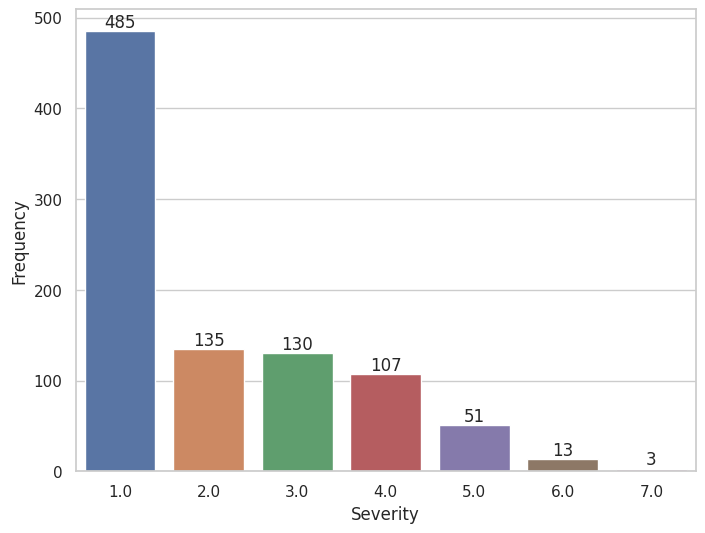

In [135]:
df = pd.concat(third_trimester, ignore_index=True)
print(len(df))
print(len(df[df['fatigue'] == 1.0]))
df

4408
2283


,date,user_id,fatigue
0,2021-06-22,39,3.0
1,2021-06-23,39,1.0
2,2021-06-24,39,1.0
3,2021-06-25,39,1.0
4,2021-06-26,39,1.0
...,...,...,...
4403,2023-05-30,2664,1.0
4404,2023-05-31,2664,1.0
4405,2023-06-01,2664,1.0
4406,2023-06-02,2664,1.0


In [3]:
def display_plot(df, symptom='fatigue', window=None):
    df = pd.concat(df, ignore_index=True)
    sns.set(style="whitegrid")  # Set the plot style
    plt.figure(figsize=(8, 6))  # Set the figure size
    
    ax = sns.countplot(x=symptom, data=df)  # Create the count plot
    # plt.title('Frequency Plot of Categories')
    ax.bar_label(ax.containers[0])
    plt.xlabel('Severity')
    plt.ylabel('Frequency')
    plt.savefig(f'../results/symptom_{symptom}_window{window}.png')
    plt.show()  # Display the plot

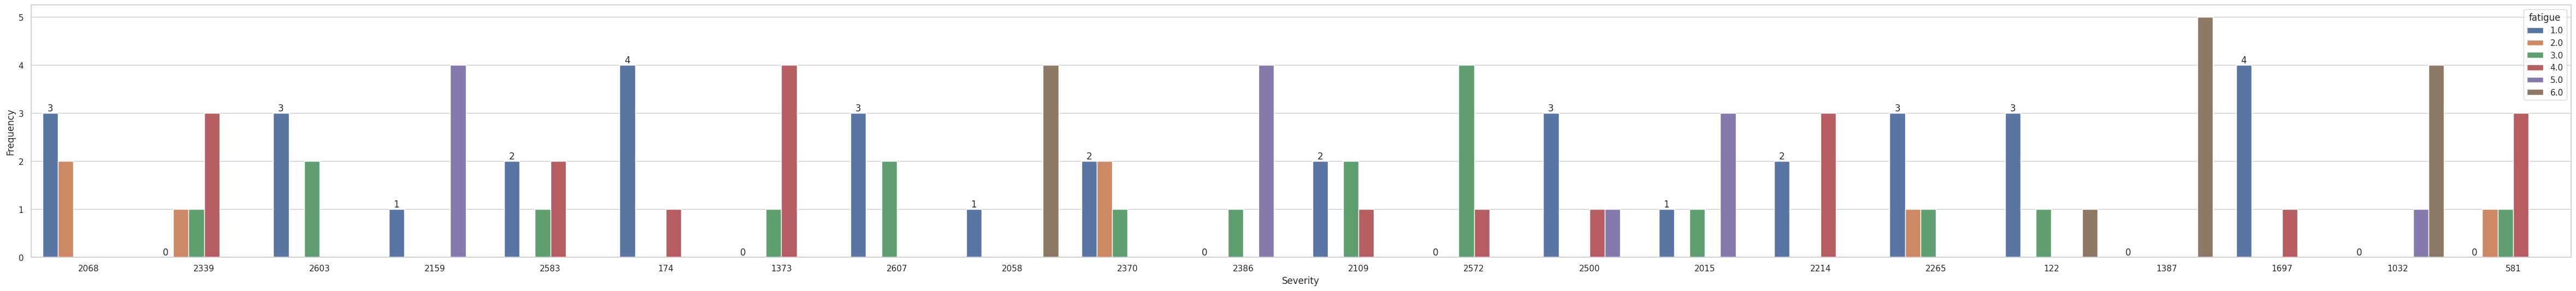

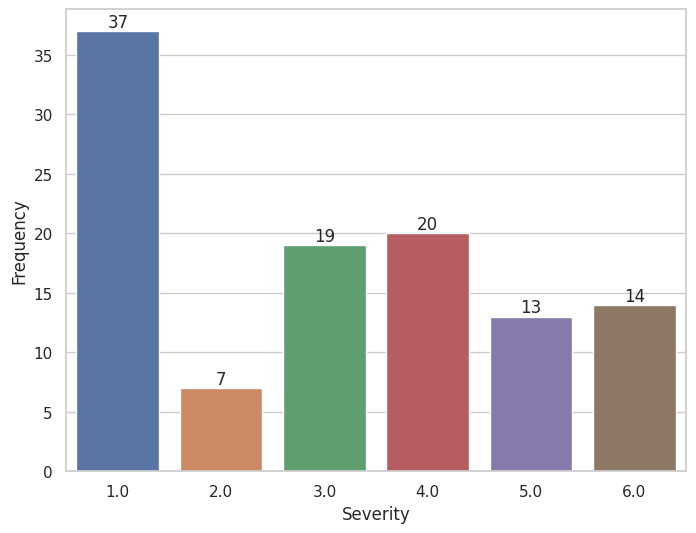

In [29]:
def display_plot_by_user(df, symptom='fatigue', window=None):
    df = pd.concat(df, ignore_index=True)
    sns.set(style="whitegrid")  # Set the plot style
    plt.figure(figsize=(60, 6))  # Set the figure size
    
    ax = sns.countplot(data=df, x='user_id', hue=symptom)  # Create the count plot
    # plt.title('Frequency Plot of Categories')
    ax.bar_label(ax.containers[0])
    plt.xlabel('Severity')
    plt.ylabel('Frequency')
    plt.savefig(f'../results/symptom_{symptom}_window{window}_byuser.png')
    plt.show()  # Display the plot
window = 3
symptom='fatigue'
dfs = get_aggregated_data_from_slice(symptom='fatigue', window=window, test_only=True)

display_plot_by_user(dfs, symptom='fatigue', window=window)
display_plot(dfs, symptom='fatigue', window=window)

In [289]:
def pie_plot(df, symptom="fatigue", threshold=5.0):
    df = pd.concat(df, ignore_index=True)
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
    
    plt.figure(figsize=(8, 8))  # Set the figure size (width, height)

# Adjust subplot parameters (optional)
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)  # Adjust margins as needed
    plt.show()
    df[df[symptom] > threshold] = threshold
    s = df[symptom].value_counts()
    print(list(s.index))
    label_lst = list(s.index)
    for i in range(len(label_lst)):
        if label_lst[i] == threshold:
            label_lst[i] = f'{threshold}-7.0'
    plt.pie(s,labels = label_lst, autopct=autopct_format(s))
    # plt.legend(s.index, title='Labels', loc='best')
    plt.savefig(f'../results/symptom_{symptom}_pie.png', bbox_inches='tight', pad_inches=0)
    

In [290]:
first_trimester = get_aggregated_data(3)
second_trimester = get_aggregated_data(2)
third_trimester = get_aggregated_data(1)


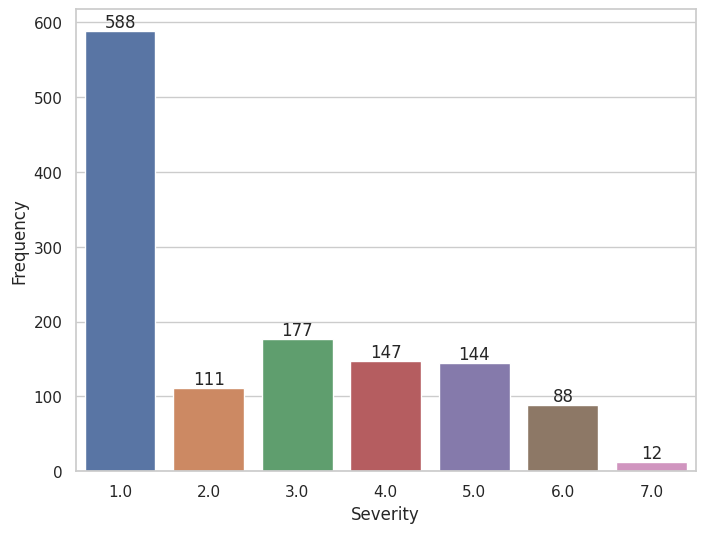

In [291]:
display_plot(first_trimester)

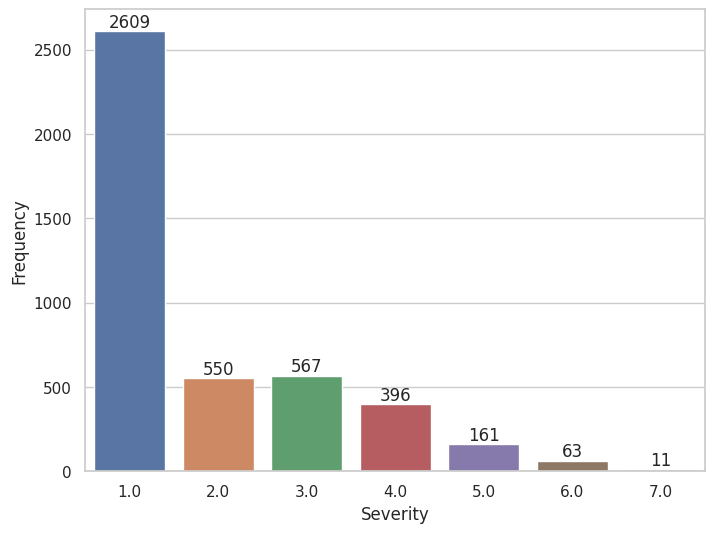

In [292]:
display_plot(second_trimester)

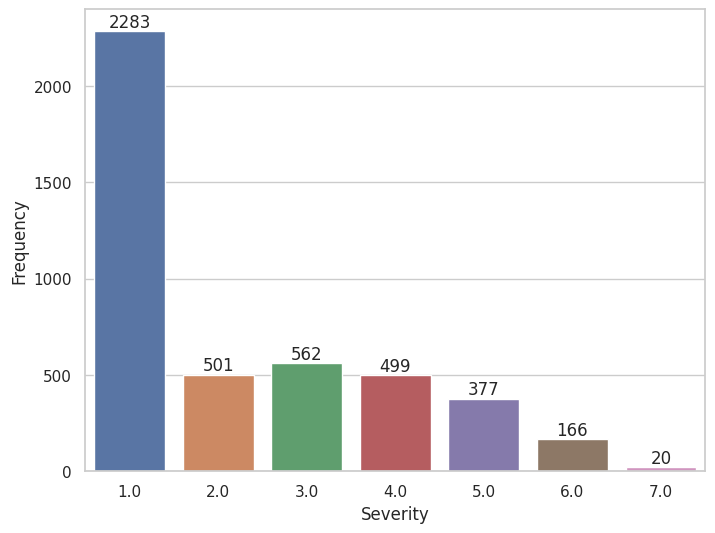

In [293]:
display_plot(third_trimester)

<Figure size 800x800 with 0 Axes>

[1.0, 5.0, 3.0, 2.0, 4.0]


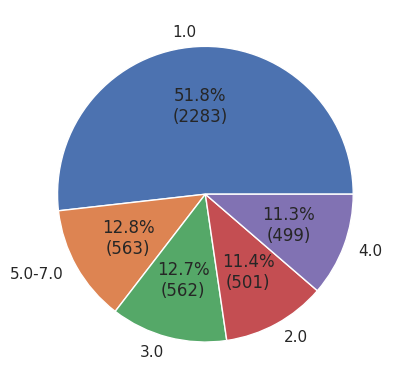

In [294]:
pie_plot(third_trimester)

In [295]:
first_trimester = get_aggregated_data(3, 'edema')
second_trimester = get_aggregated_data(2, 'edema')
third_trimester = get_aggregated_data(1, 'edema')


In [296]:
df = pd.concat(third_trimester, ignore_index=True)
print(len(df))
print(len(df[df['edema'] == 1.0]))
df

20970
17967


,date,user_id,edema
0,2021-05-17,28,1.0
1,2021-05-18,28,1.0
2,2021-05-19,28,1.0
3,2021-05-20,28,1.0
4,2021-05-21,28,1.0
...,...,...,...
20965,2023-04-22,2656,3.0
20966,2023-04-23,2656,3.0
20967,2023-04-24,2656,3.0
20968,2023-04-25,2656,3.0


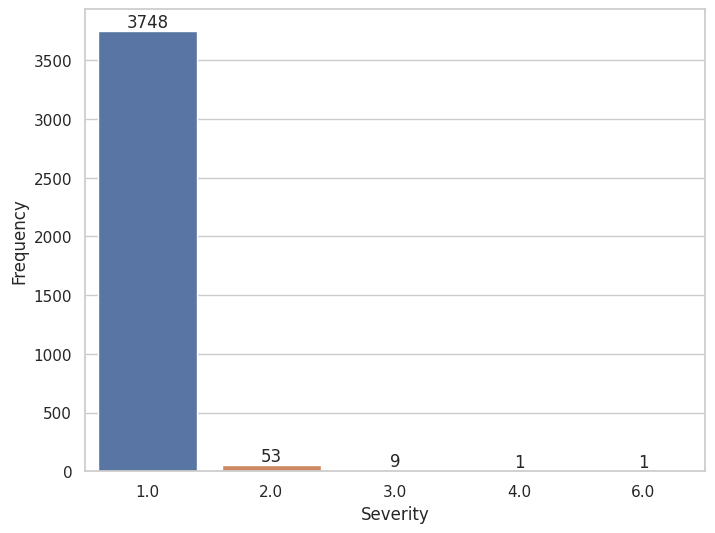

In [297]:
display_plot(first_trimester, 'edema')

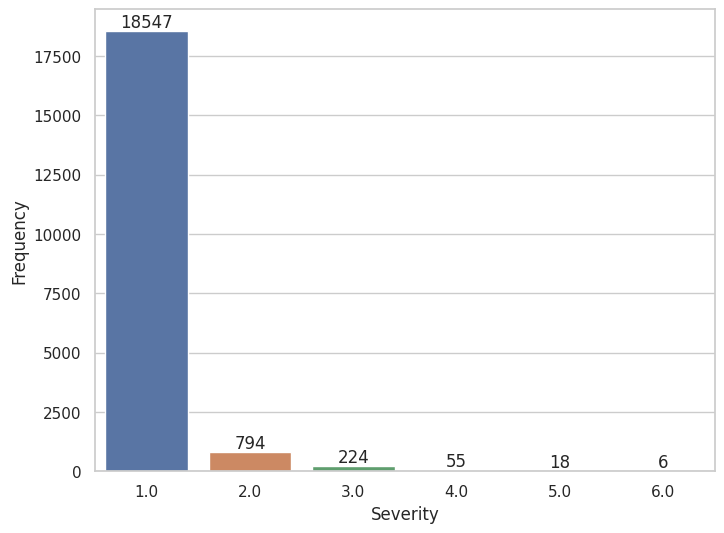

In [298]:
display_plot(second_trimester,'edema')

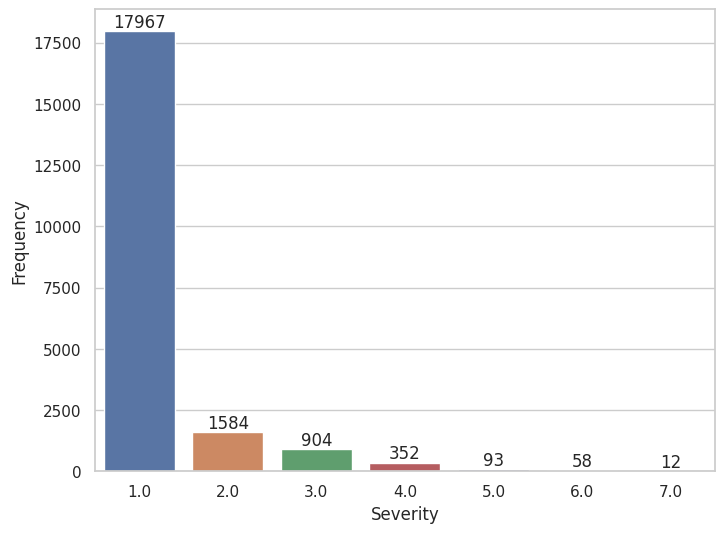

In [299]:
display_plot(third_trimester,'edema')

<Figure size 800x800 with 0 Axes>

[1.0, 2.0, 3.0]


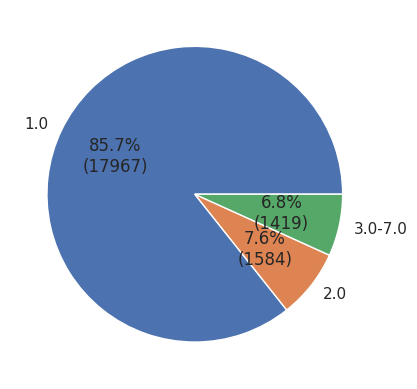

In [300]:
pie_plot(third_trimester, "edema", 3.0)

In [307]:
import numpy as np
import pandas as pd
from chord import Chord

# Example adjacency matrix
adjacency_matrix = np.array([
    [0, 2, 1, 0],
    [2, 0, 0, 1],
    [1, 0, 0, 2],
    [0, 1, 2, 0]
])

# Create a DataFrame from the adjacency matrix for labeling
labels = ['A', 'B', 'C', 'D']
adjacency_df = pd.DataFrame(adjacency_matrix, index=labels, columns=labels)

# Create the chord diagram with labels
chord = Chord(adjacency_df, names=labels)

# Plot the chord diagram
chord.to_html("../chord-diagram-chord-library.html")


TypeError: Object of type DataFrame is not JSON serializable